In [2]:
using JLD2, FileIO, FITSIO, FITSTables, DataFrames, CSV, PyPlot, PyCall
LogNorm = pyimport("matplotlib.colors").LogNorm
include("get_lamost_spectra.jl")
include("fitsdf.jl")
;

### load battery, dr2, praesepe sets

In [3]:
lamost = FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5-v3-stellar.fits.gz")

tenth = Set(CSV.read("one_tenth_of_LAMOST.csv").obsid);

battery = DataFrame()
FITS("../cats/the-battery-stars.rc.fits") do hdus
    battery.fn = read(hdus[2], "lamost_id")
    battery.ra = read(hdus[2], "ra")
    battery.dec = read(hdus[2], "dec")
end
battery = join(battery, lamost, on=[:ra, :dec]);
battery = Set(battery.obsid) ∩ tenth

dr2 = FITS("../cats/LAMOST-dr2-stellar.fits.gz") do hdus
    Set(read(hdus[2], "obsid"))
end

pleiades = CSV.read("../cats/LAMOST-dr4v2-pleiades-members.csv")
pleiades = Set(pleiades.designation) ;

### load test results

In [4]:
dfs = Dict()
for (k, fn) in [#("ds", "distributed_topsnr_1000_test.classified.fits"),
                #("ds10k", "distributed_topsnr_10000_test.classified.fits"),
                ("d", "distributed_test.classified.fits"),
                #("r", "random_test.classified.fits"),
                ("r", "random_30000_test.classified.fits")]
                #("s", "topsnr_test.classified.fits")]
    dfs[k] = join(fitsdf(fn, 2), lamost[:, [:obsid, :teff, :feh, :logg, :snrz, :designation]], on=:obsid, kind=:left)
end

In [5]:
dfs["r"].snrz = Float32.(dfs["r"].snrz);

In [6]:
dfs["d"].snrz = Float32.(dfs["d"].snrz);

MethodError: MethodError: no method matching Float32(::Missing)
Closest candidates are:
  Float32(!Matched::Int8) at float.jl:60
  Float32(!Matched::Int16) at float.jl:60
  Float32(!Matched::Int32) at float.jl:60
  ...

In [7]:
dropmissing!(dfs["d"])
dropmissing!(dfs["r"])
;

### compare basic stats

In [11]:
for (k, df) in dfs
    println("$k")
    df.inbat = map(eachrow(df)) do row
        row.obsid in battery
    end

    df.oldcat = map(eachrow(df)) do row
        (row.obsid in dr2) && (row.logg .< 3)
    end   
    
    cut = 50#quantile(df[df.isline .& (df.amplitude .> 0), :delta_chi2], 0.98)
    println("using Δχ^2 > $cut")
    df.match = df.isline .& (df.amplitude .> 0) .& (df.delta_chi2 .> cut)
    println(sum(df.match))
    
    println("fraction of all spectra that get flagged: ", sum(df.match) / size(df, 1))
    println("fraction of all spectra that match an absorption line model: ", sum(df.isline .& (df.amplitude .> 0)) / size(df, 1))
    println("fraction of battery stars that match a line model: ", sum(df.match .& df.inbat) / sum(df.inbat))
    println("$(sum(df.match .& df.inbat)) match &  battery")
    println("$(sum(df.match .& (.! df.inbat))) match & ¬battery")
    println("$(sum((.! df.match) .& df.inbat)) ¬match & battery")
    println("$(sum((.! df.match) .& (.! df.inbat))) ¬match & ¬battery")
    
    println("flagged $(sum(df[df.oldcat, :match])) including $(sum(df[df.oldcat, :match] .& df[df.oldcat, :inbat])) of $(sum(df[df.oldcat, :inbat])) in battery for DR2 giants")
    println()
end

r
using Δχ^2 > 50
917
fraction of all spectra that get flagged: 0.0017153300373556606
fraction of all spectra that match an absorption line model: 0.08129579435493677
fraction of battery stars that match a line model: 0.4827586206896552
14 match &  battery
903 match & ¬battery
15 ¬match & battery
533659 ¬match & ¬battery
flagged 180 including 11 of 26 in battery for DR2 giants

d
using Δχ^2 > 50
658
fraction of all spectra that get flagged: 0.0014524969482111992
fraction of all spectra that match an absorption line model: 0.02849145609507895
fraction of battery stars that match a line model: 0.5588235294117647
152 match &  battery
506 match & ¬battery
120 ¬match & battery
452235 ¬match & ¬battery
flagged 169 including 138 of 241 in battery for DR2 giants



In [1]:
plt.hist(dfs["r"].delta_chi2, range=[0, 200])
yscale("log")

UndefVarError: UndefVarError: dfs not defined

Set(Union{Missing, String}["J034521.18+234338.9", "J034411.20+232245.5", "J035040.07+235559.0"])
Set(

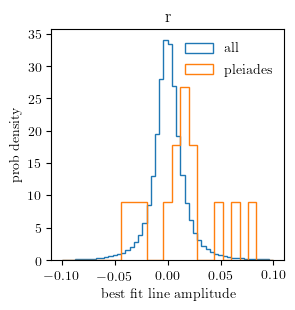

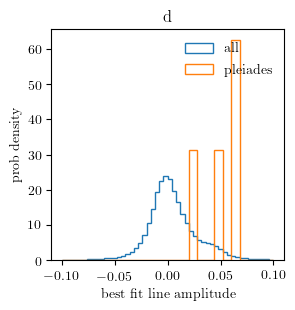

Union{Missing, String}["J033927.80+235341.9", "J034507.62+215945.4", "J034513.92+263518.2"])


In [39]:
for (k, df) in dfs
    figure(figsize=(3,3))
    r = (-0.1,0.1)
    plt.hist(df.amplitude, density=true, range=r, bins=50, histtype="step", label="all")
    title(k)
    println(Set(df.designation[df.match]) ∩ pleiades)
    ylabel("prob density")
    xlabel("best fit line amplitude")
    plt.hist(df.amplitude[[d in pleiades for d in df.designation]], density=true, range=r, bins=25, histtype="step", label="pleiades")
    legend()
end

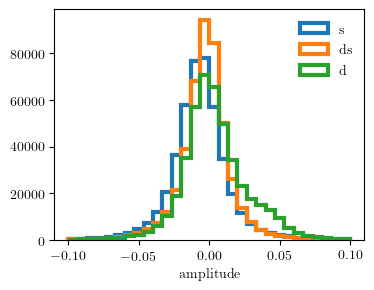

PyObject Text(0.5, 22.299550986642963, 'amplitude')

In [47]:
figure(figsize=(4,3))
for (m, df) in dfs
    plt.hist(df.amplitude, label=m, range=(-.1,.1), bins=30, histtype="step", lw=3)
end
legend()
xlabel("amplitude")

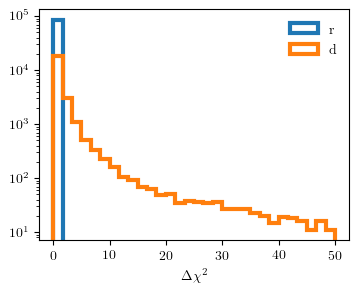

PyObject Text(0.5, 23.953884953991974, '$\\Delta \\chi^2$')

In [25]:
figure(figsize=(4,3))
for (m, df) in dfs
    plt.hist(df.delta_chi2, label=m, range=(0,50), bins=30, histtype="step", lw=3)
#    plt.hist(df.delta_chi2[[d in pleiades for d in df.designation]], 
#        normed=true, bins=25, histtype="step", lw=3)
end
legend()
plt.yscale("log")
xlabel(L"\Delta \chi^2")

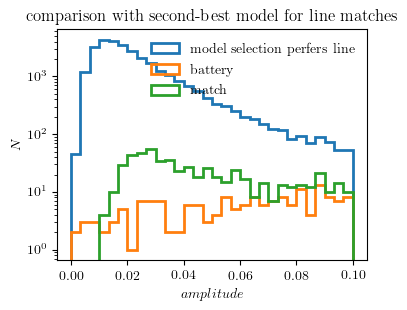

PyObject Text(0.5, 1, 'comparison with second-best model for line matches')

In [53]:
figure(figsize=(4,3))
df = dfs["ds"]
plt.hist(df[df.isline, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="model selection perfers line", lw=2)
plt.hist(df[df.inbat, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="battery", lw=2)
plt.hist(df[df.match, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="match", lw=2)
legend()
plt.yscale("log")
ylabel(L"N")
#xlabel(L"\Delta \chi^2")
xlabel(L"amplitude")
title("comparison with second-best model for line matches")

# we are missing low-S/N candidates

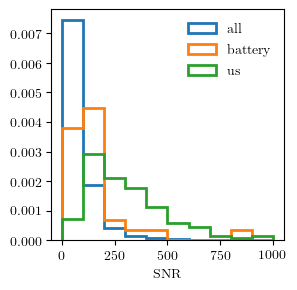

PyObject Text(0.5, 22.299550986642963, 'SNR')

In [61]:
include("../cats/human_readable_names.jl")
#for (m, df) in dfs
figure(figsize=(3,3))
df = dfs["r"]
col=:snrz
range=[0,1000]
plt.hist(df[!, col], histtype="step", lw=2, density=true, label="all", range=range)
plt.hist(df[df.inbat, col], histtype="step", lw=2, density=true, label="battery", range=range)
plt.hist(df[df.match, col], histtype="step", lw=2, density=true, label="us", range=range)
legend()
xlabel("SNR")
#end

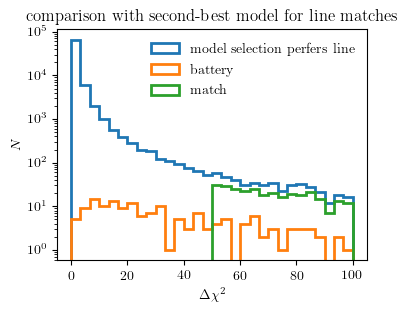

PyObject Text(0.5, 1, 'comparison with second-best model for line matches')

In [55]:
figure(figsize=(4,3))
df = dfs["r"]
plt.hist(df[df.isline, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="model selection perfers line", lw=2)
plt.hist(df[df.inbat, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="battery", lw=2)
plt.hist(df[df.match, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="match", lw=2)
legend()
plt.yscale("log")
ylabel(L"N")
xlabel(L"\Delta \chi^2")
title("comparison with second-best model for line matches")

# lithium science

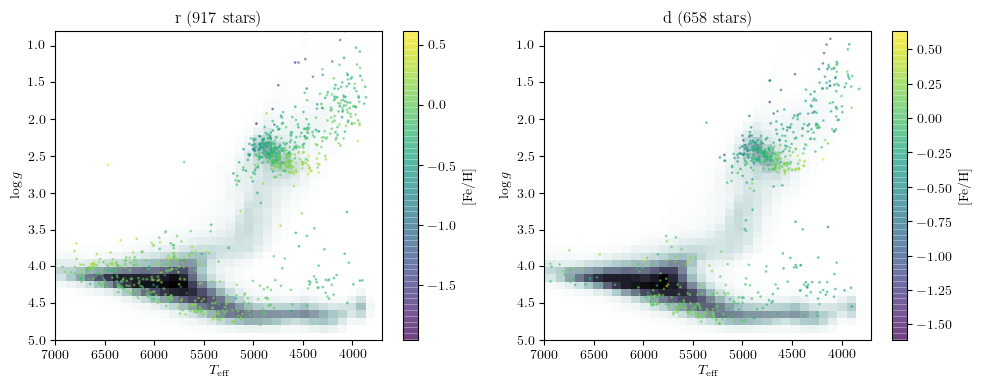

In [70]:
axs = subplots(1, 2, figsize=(10, 4))[2]
for (i, (k, df)) in enumerate(dfs)
    sca(axs[i])
    title("$k ($(sum(df.match)) stars)")
    plt.hist2d(df.teff, df.logg, cmap="bone_r", bins=50, zorder=-1)#, norm=LogNorm())
    scatter(df[df.match, :teff], df[df.match, :logg], s=1, label=string(k), c=df[df.match, :feh], alpha=0.5, cmap="viridis")
    colorbar(label="[Fe/H]")
    gca().invert_yaxis()
    gca().invert_xaxis()
    xlim(7000, 3700)
    ylim(5, 0.8)
    xlabel(L"T_\mathrm{eff}")
    ylabel(L"\log g")
end
tight_layout()

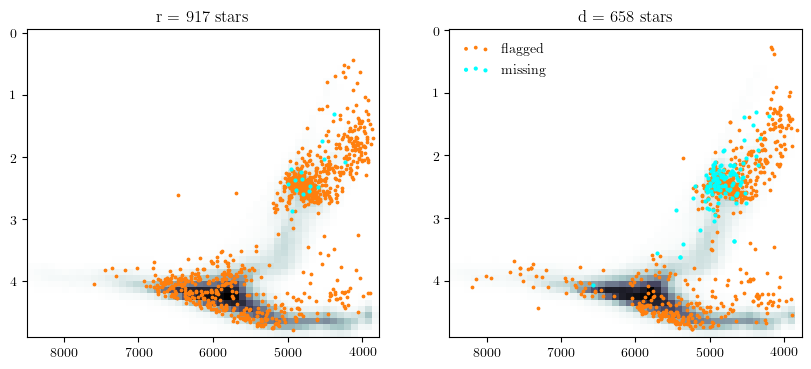

PyObject <matplotlib.legend.Legend object at 0x15be4de10>

In [71]:
axs = subplots(1, 2, figsize=(10, 4))[2]
for (i, (k, df)) in enumerate(dfs)
    sca(axs[i])
    title("$k  = $(sum(df.match)) stars")
    plt.hist2d(df.teff, df.logg, cmap="bone_r", bins=50, zorder=-1)#, norm=LogNorm())
    scatter(df[df.match, :teff], df[df.match, :logg], s=3, c="C1", label="flagged")
    mask = df.inbat .& (.! df.match)
    scatter(df[mask, :teff], df[mask, :logg], s=4, c="cyan", label="missing")
    #xlim(3600, 6000)
    #ylim(0,4)
    gca().invert_yaxis()
    gca().invert_xaxis()
end
legend()


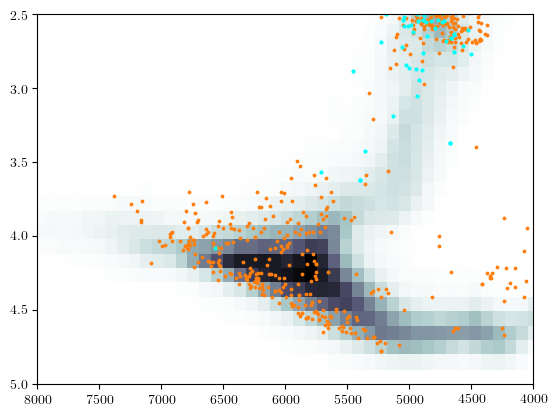

(8000, 4000)

In [59]:
df = dfs["ds"]
plt.hist2d(df.teff, df.logg, cmap="bone_r", bins=50, zorder=-1)#, norm=LogNorm())
scatter(df[df.match, :teff], df[df.match, :logg], s=3, c="C1", label="flagged")
mask = df.inbat .& (.! df.match)
scatter(df[mask, :teff], df[mask, :logg], s=4, c="cyan", label="missing")
ylim(5, 2.5)
xlim(8000,4000)

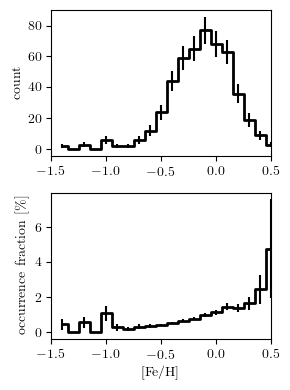

In [74]:
using StatsBase
df = dfs["r"]
fehbins=-1.5:0.1:0.5

gmatch = df.match .& (df.logg .< 3)

axs = subplots(2, 1, figsize=(3,4))[2]

h = fit(Histogram, df[gmatch, :feh], fehbins)
h2 = fit(Histogram, df[df.logg .< 3, :feh], fehbins)
midpoints = h.edges[1][1:end-1] + diff(h.edges[1])

sca(axs[1])
plt.errorbar(midpoints, h.weights, sqrt.(h.weights), ls="", c="k")
plt.step(midpoints, h.weights, where="mid", lw=2, c="k")
ylabel("count")
xlim(-1.5, 0.5)

sca(axs[2])
plt.errorbar(midpoints, h.weights./h2.weights * 100, 
    sqrt.(h.weights .+ h.weights.^2 ./ h2.weights)./h2.weights * 100, ls="", c="k")
plt.step(midpoints, h.weights./h2.weights * 100 , lw=2, where="mid", c="k")
ylabel("occurrence fraction [\\%]")
xlabel("[Fe/H]")
xlim(-1.5, 0.5)
tight_layout()
savefig("../../Desktop/occurance_rate.pdf", bbox_inches="tight")

# look at spectra

In [61]:
wl_grid = load("wl_grid.jld2")["wl_grid"]
Δλ = 7                                                                          
    
li_air = 6707.85
include("air_vacuum.jl")
li_vac = air_to_vac(li_air)
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ
;

In [62]:
ϕ(x, μ, σ) = exp(-1/2 * (x-μ)^2/σ^2) #gaussian kernel                       
n = sum(line_mask)
M = zeros(2 + n, n)                                                         
M[1, :] = ϕ.(wl_grid[line_mask], li_vac, li_air/3600)
M[1, :] ./= sqrt(sum(M[1, :].^2))
M[2, :] .= sqrt(1/n)
for i in 3:(2+n)
    M[i, i-2] = 1.
end 

In [2]:
function plot_spectrum(row)
    
    print("obsid: ", row.obsid)
    println(" ... in the battery? $(row.obsid in battery)")
    
    download_lamost_spectra([row.obsid], verbose=false)
    wl, flux, ivar = load_lamost_spectrum(row.obsid)
    download_lamost_spectra(row.neighbors, verbose=false)
    F = hcat((n->load_lamost_spectrum(n)[2]).(row.neighbors)...)
    
    #figure(figsize=(3,3))
    #ylabel("residuals")
    #xlabel(L"$\lambda$ [\AA]")
    #errorbar(wl[line_mask], row.diff, yerr=row.err, label="data")
    #errorbar(wl[line_mask], M[1, :]*row.amplitude, label="best fit line model")
    #legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    plt.plot(wl, flux, label="data")
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl, flux, yerr=ivar.^(-1/2), label="data");
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    errorbar(wl[line_mask], F[line_mask, :] * row.weights .- M[1, :]*row.amplitude, label="best fit residual model")
    legend()
    xlim(6660, 6750)
    ylim(0.9, 1.1)
    
    ;
end

LoadError: UndefVarError: @L_str not defined

[-363.421, -124.215, -0.0012058, -7.21982, -0.0116285, -3.42332, -90.9875, -183.355, -85.8909, -4.89994, -0.0180588]
180.06580724294778
obsid: 363305015 ... in the battery? false
of 1 spectra, 0 need to be downloaded


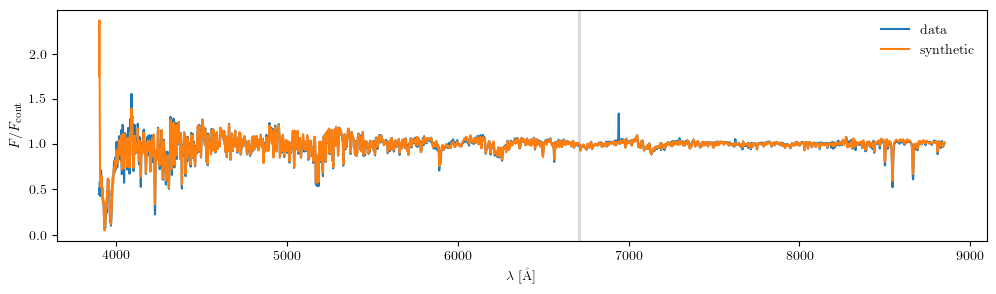

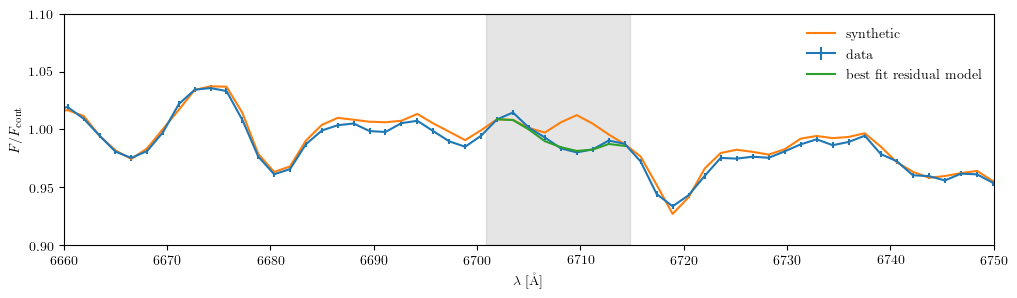

of 6 spectra, 0 need to be downloaded


(0.9, 1.1)

In [65]:
#ind = Set(dfs["ds"].obsid[dfs["ds"].match])
#i = findall(dfs["r"].match .& (.! [o in ind for o in dfs["r"].obsid]))[5]
i = findall(dfs["ds"].match)[1]
    
df = dfs["ds"]
println(df[i, :loss])
println(df[i, :delta_chi2])
plot_spectrum(df[i, :])

[-363.421, -124.215, -0.0012058, -7.21982, -0.0116285, -3.42332, -90.9875, -183.355, -85.8909, -4.89994, -0.0180588]
180.06580724294778
obsid: 363305015 ... in the battery? false
of 1 spectra, 0 need to be downloaded


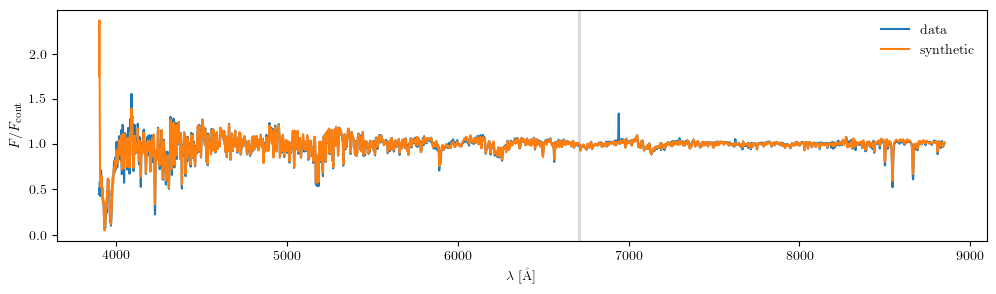

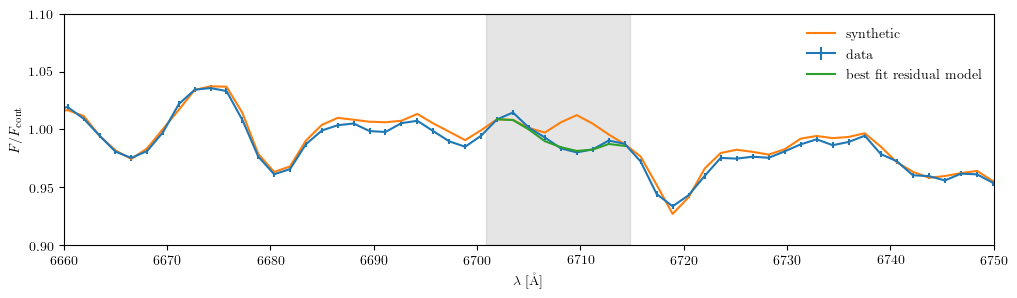

of 6 spectra, 0 need to be downloaded


(0.9, 1.1)

In [65]:
#ind = Set(dfs["ds"].obsid[dfs["ds"].match])
#i = findall(dfs["r"].match .& (.! [o in ind for o in dfs["r"].obsid]))[5]
i = findall(dfs["ds"].match)[1]
    
df = dfs["ds"]
println(df[i, :loss])
println(df[i, :delta_chi2])
plot_spectrum(df[i, :])